# Save Test Model

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import Model

In [2]:
# load the final saved trained model
arc_model = tf.keras.models.load_model('arc_model_saved', compile=False)

In [3]:
# check its architecture
arc_model.summary()

Model: "arcface_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, None, None, 2 23587712    input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2, 2, 2048)   8192        resnet50[0][0]                   
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2, 2, 2048)   0           batch_normalization[0][0]        
______________________________________________________________________________________

We want to use the trained model for generating embeddings, so we will use custom layer indexing in order to get the embeddings as output from an intermediate layer

In [4]:
# Create a model which takes a 64x64x3 image as input and returns the 64 dim embeddings as output
test_model = Model(arc_model.input[0],arc_model.layers[6].output)

In [5]:
# save the model for testing purpose
test_model.save('test_model_saved')

INFO:tensorflow:Assets written to: test_model_saved/assets


In [2]:
# load the final saved test model
test_model = tf.keras.models.load_model('test_model_saved', compile=False)

In [ ]:
# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model('test_model_saved') # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the converted model
with open('test_model_tflite', 'wb') as f:
    f.write(tflite_model)

# Get test features

In [3]:
def read_image(path):
    '''
    The function reads an image path
    Read the image from image path, decode the channels in the image
    Resize it to 64x64
    Cast it to a float32 array and normalize each pixel
    Returns the preprocessed image
    '''
    
    #read image file at the path
    image = tf.io.read_file(path)
    
    image = tf.image.decode_jpeg(image, channels=3)
    
    #resize image
    image = tf.image.resize(image, [64,64])
    
    #convert to float32
    image = tf.cast(image, tf.float32)
    
    # normalize image to [0,1] range
    image /= 255.0
    
    
    return image

In [4]:
# read a test image
test_image = np.expand_dims(read_image('hotel-id-2021-fgvc8/test_images/b5cc62ab665591a9.jpg'),0)

In [ ]:
#read the optimized tflite test model
test_model = tf.lite.Interpreter('test_model_tflite')

In [ ]:
#allocate the tensors
test_model.allocate_tensors()

In [ ]:
# Get input and output tensors.
input_details = test_model.get_input_details()
output_details = test_model.get_output_details()

In [ ]:
#set the input details tensor in the test model
test_model.set_tensor(input_details[0]['index'], test_image)

In [ ]:
#invoke the test model
test_model.invoke()

In [14]:
# The function `get_tensor()` returns a copy of the tensor data
test_embeds = test_model.get_tensor(output_details[0]['index'])
print(test_embeds)

[[ 3.4352622   1.2038461  -5.614873   -3.0531971   1.096702   -0.70200026
  -0.4489979   0.54013014  0.17574799  1.8162487  -1.8360224   1.2028728
  -3.4211504  -4.48044     0.49442798 -1.5795695  -1.5396396   0.04684472
   1.6759751   0.22563194  0.9359001   0.6462988   1.3824761   0.7510697
   0.6354063  -1.4954247  -2.481701   -1.5540028   0.51154953  1.0043945
  -0.22262004  1.0152125   0.36912164  1.7513998   2.0259748   0.58725154
  -1.7369018  -0.8863448   3.7699814  -1.0321298  -0.03182679 -0.28562158
  -1.2936962  -0.13130541  1.4472108  -0.39802253  0.8797833   1.7477694
   1.1165631   2.48949    -0.8398092   0.23413655  1.3929284  -1.7945713
  -2.5276747  -0.07483505 -1.418865   -0.3962403  -0.49967793 -0.09434804
  -7.20872     1.0612941  -2.428517   -0.14393985]]


In [24]:
# normalize the embeddings
norm = np.linalg.norm(test_embeds, axis=1, keepdims=True)
test_embeds = test_embeds / norm
test_embeds

array([[ 0.22299978,  0.07814758, -0.36448905, -0.19819805,  0.07119232,
        -0.04557029, -0.02914667,  0.03506251,  0.01140867,  0.11790164,
        -0.11918525,  0.07808439, -0.22208372, -0.29084742,  0.03209575,
        -0.10253763, -0.09994558,  0.00304092,  0.10879579,  0.01464688,
         0.06075388,  0.04195444,  0.08974333,  0.04875563,  0.04124735,
        -0.09707538, -0.16109942, -0.10087797,  0.0332072 ,  0.06520019,
        -0.01445136,  0.06590244,  0.0239615 ,  0.11369198,  0.131516  ,
         0.03812139, -0.11275084, -0.057537  ,  0.24472804, -0.06700062,
        -0.00206603, -0.0185411 , -0.08398019, -0.00852368,  0.09394558,
        -0.0258376 ,  0.05711106,  0.11345631,  0.0724816 ,  0.16160505,
        -0.05451615,  0.01519896,  0.09042183, -0.11649445, -0.16408381,
        -0.00485791, -0.09210551, -0.02572191, -0.03243655, -0.0061246 ,
        -0.4679535 ,  0.06889382, -0.157647  , -0.00934384]],
      dtype=float32)

# Get train features

In [8]:
# Read train data
train_df = pd.read_csv('hotel-id-2021-fgvc8/train.csv')

In [9]:
# store the image path as the absolute path because each image is contained in a folder of some hotel chain
train_df['image_path'] = "hotel-id-2021-fgvc8/train_images/" + train_df['chain'].astype(str) +'/'+ train_df['image']

In [17]:
# save the image paths as a tensor
train_filenames  = tf.convert_to_tensor(train_df['image_path'].tolist(), dtype=tf.string)

# Create a train dataset

# read all the train file names to create a Dataset type object
train_dataset = tf.data.Dataset.from_tensor_slices(train_filenames)

# shuffle the dataset
train_dataset = train_dataset.shuffle(len(train_filenames))

# Map the read_train_image function on the dataset in order to read dataset
train_dataset = train_dataset.map(read_image,num_parallel_calls=4)

#batch and prefetch the dataset
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.prefetch(2)

# check shape of train dataset
train_dataset

<PrefetchDataset shapes: (None, 64, 64, 3), types: tf.float32>

In [21]:
#get embeddings for the train images using the saved test model
train_embeds = test_model.predict(train_dataset)

In [22]:
# check the shape of the embeddings
train_embeds.shape

(97556, 64)

In [23]:
# normalize the embeddings
norm = np.linalg.norm(train_embeds, axis=1, keepdims=True)
train_embeds = train_embeds / norm
train_embeds

array([[ 0.20505849,  0.10567163, -0.3208447 , ...,  0.03358547,
        -0.20073994,  0.03888075],
       [ 0.21699972,  0.10762458, -0.3227249 , ...,  0.04222252,
        -0.18759897,  0.03901464],
       [ 0.19534366,  0.08760874, -0.3565677 , ...,  0.03252538,
        -0.16914774,  0.05171287],
       ...,
       [ 0.20147462,  0.09527556, -0.3160532 , ...,  0.01868967,
        -0.21584763,  0.05319561],
       [ 0.20638838,  0.07409547, -0.3412402 , ...,  0.01476231,
        -0.14633878, -0.00448954],
       [ 0.18508849,  0.10021146, -0.33109757, ...,  0.05959033,
        -0.15728399,  0.05662606]], dtype=float32)

In [24]:
# save the train embeddings
np.save('train_embeddings.npy',train_embeds)

# KMeans clustering

Lets train a kmeans model using faiss, to predict the nearest hotel ids as well as get the error metrics

In [9]:
!pip install faiss-cpu

  Using cached faiss_cpu-1.7.1.post2-cp39-cp39-macosx_10_14_x86_64.whl (2.0 MB)
You should consider upgrading via the '/Users/prachi/py3/bin/python3.9 -m pip install --upgrade pip' command.


In [10]:
#import the faiss library
import faiss

In [11]:
# load the train embeddings
train_embeds = np.load('train_embeddings.npy')

In [12]:
# define the hyperparameters - no. of dimensions, no. of clusters(centroids), no. of iterations
dim = train_embeds.shape[1]
n_centroids = 7770
n_iter = 20
verbose = True

In [13]:
# define a kmeans model with the hyper parameters and train the model with train embeddings
kmeans = faiss.Kmeans(dim, n_centroids, niter=n_iter, verbose=verbose)
kmeans.train(train_embeds)

911.9863891601562

In [14]:
# the error after training for n iterations
kmeans.obj[-1]

911.9863891601562

In [24]:
import pickle

In [8]:
# save the error for future reference
with open("kmeans_error.pkl", "wb") as f:
    pickle.dump(kmeans.obj[-1], f)

In [15]:
# return the nearest centroid and its distance for each line vector in train_embeds
train_to_centroid_dist, train_to_centroid_ind = kmeans.index.search(train_embeds, 1)

In [16]:
# check the shape of results
train_to_centroid_dist.shape

(97556, 1)

In [17]:
# check the number and dimensions of centroids found
kmeans.centroids.shape

(7770, 64)

In [37]:
# train an index with the centroids found from trained kmeans model
kmeans_index = faiss.IndexFlatL2(dim)
kmeans_index.add(kmeans.centroids)

In [38]:
# save the trained index
faiss.write_index(kmeans_index, "kmeans_trained.index")

In [18]:
# load the saved index
kmeans_index = faiss.read_index("kmeans_trained.index")

In [19]:
#find the 5 nearest distance in test_embeds to the computed centroids
test_to_centroid_dist, test_to_centroid_ind = kmeans_index.search(test_embeds, 5)

In [20]:
# check the number of distances returned
test_to_centroid_dist.shape

(1, 5)

In [21]:
# check distances
test_to_centroid_dist

array([[0.00697982, 0.01082618, 0.01118837, 0.01142325, 0.01222723]],
      dtype=float32)

In [22]:
# check the nearest centroid indices
test_to_centroid_ind

array([[5556, 3763, 2977, 6619, 5562]])

In [25]:
# load the saved label encoder
with open('le.pkl', "rb") as input_file:
    le = pickle.load(input_file)

/Users/prachi/py3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [26]:
# get the actual labels for these predicted labels (which were transformed earlier using label encoder)
actual_output_labels = le.inverse_transform(test_to_centroid_ind[0])
actual_output_labels

array([46960, 31775, 24854, 55706, 47003])

# Visualization

In [27]:
# import required libraries for visualization of clusters and nearest centroids to test data
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set()

In [3]:
# load the train embeddings
train_embeds = np.load('train_embeddings.npy')

In [158]:
# reduce the high dimensional data to 2D for visualization
pca1 = PCA(2)
pca2 = PCA(2)
 
#Transform the data
centroids = pca1.fit_transform(kmeans.centroids)
train_data = pca2.fit_transform(train_embeds)


In [4]:
import pickle

In [159]:
#save the dimensionality reduced centroids
pickle.dump(centroids, open('kmeans_centroids_pca.pkl', 'wb'))

In [7]:
#read the train data csv
train_df = pd.read_csv('hotel-id-2021-fgvc8/train.csv')

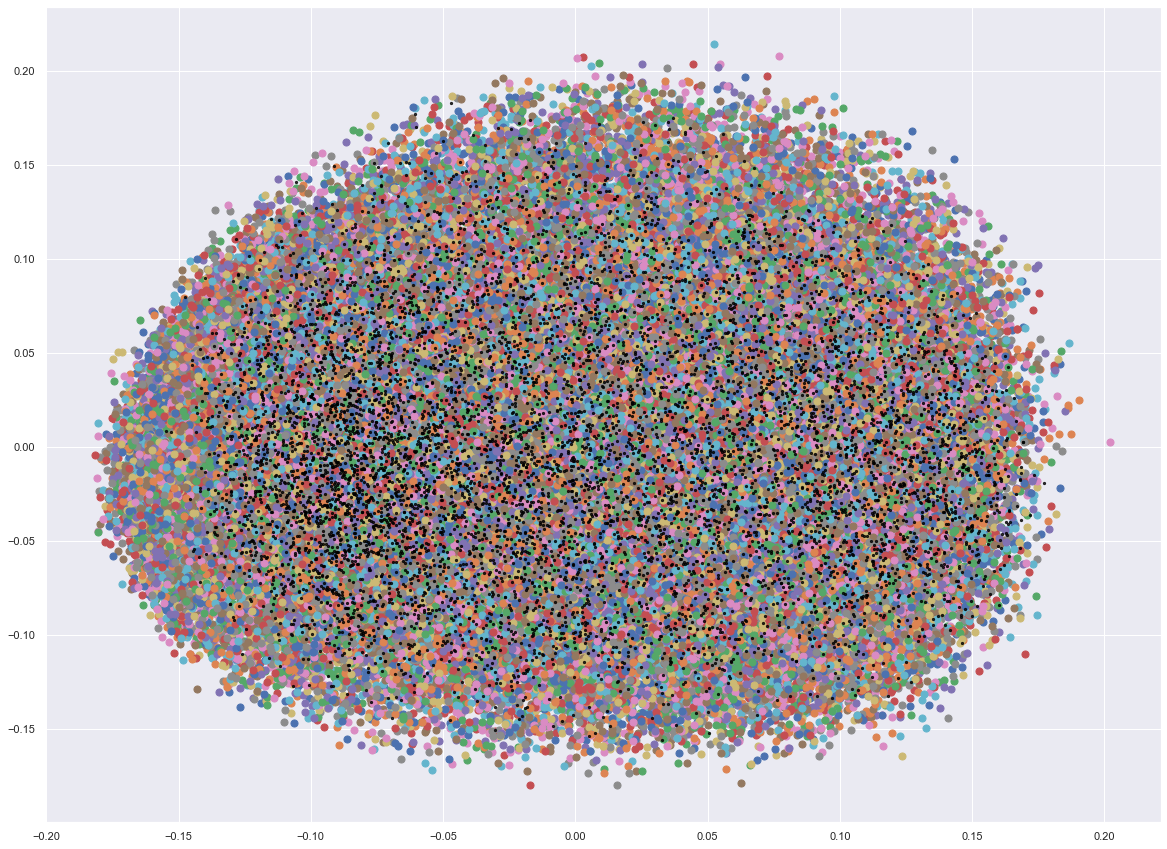

In [155]:
''' Saving the plot which has the train embeddings along with the cluster centers (classes)'''
#create the figure size
fig,ax = plt.subplots(1,1)
fig.set_size_inches(20, 15)

#get the unique original hotel id's from the train csv
u_labels = np.unique(train_df['hotel_id'])
 

#plotting the results:

#iterate over the unique hotel id's
for i in u_labels:
    
    #plot the images of each unique hotel id in a separate colour
    ax.scatter(train_data[train_df['hotel_id']==i,0] , train_data[train_df['hotel_id']==i,1], cmap='viridis', s=50)
    
#plot the centroids of each of the above cluster
ax.scatter(centroids[:,0] , centroids[:,1], s = 5, color = 'black',alpha=0.8,label='Hotel ID centroid')

#for faster access, saving this master plot which serves as a common plot for each inference
pickle.dump((fig,ax), open('train_fig.pkl', 'wb'))

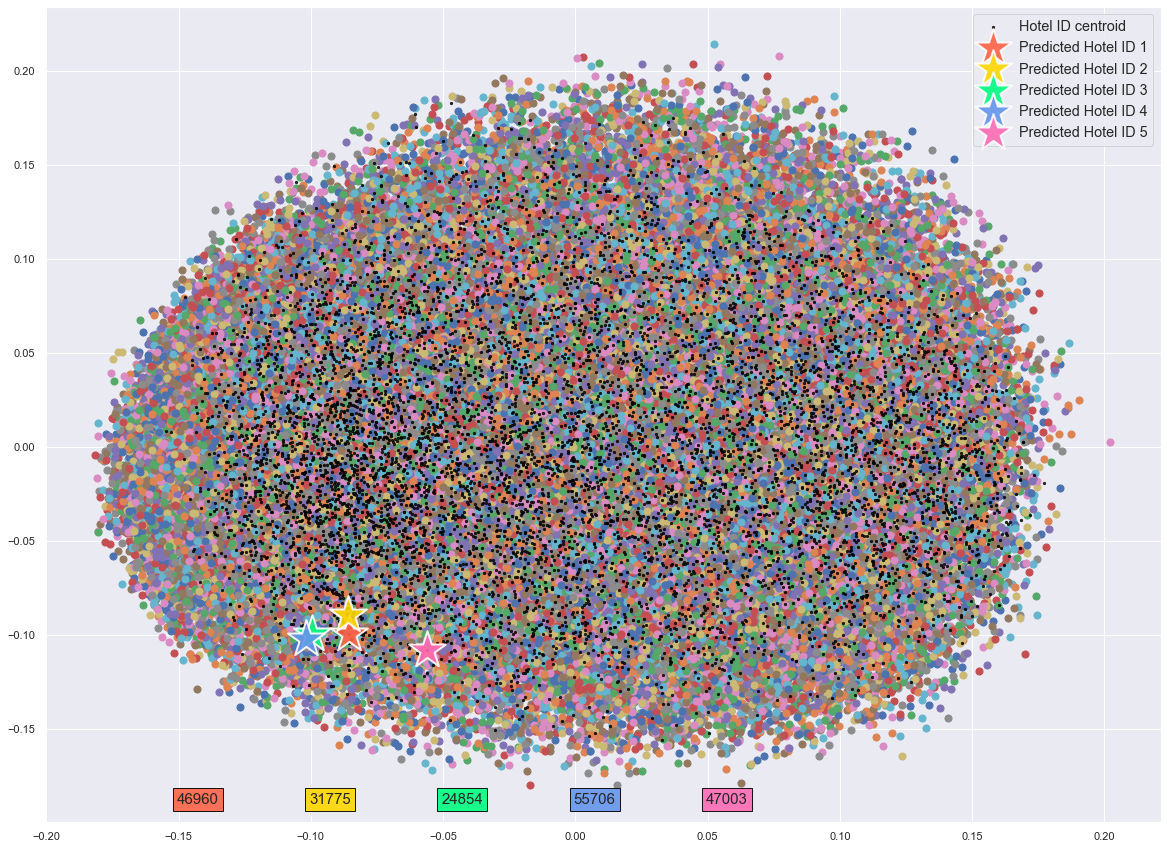

In [28]:
''' Loading the saved master plot which has the train embeddings along with the cluster centers (classes)
    and plotting the inference predictions on top of it
'''

#load the saved plot and unpack to its figure and axes
fig2,ax2 = pickle.load(open('train_fig.pkl', 'rb'))
fig2.set_size_inches(20, 15)

##load the dimensionality reduced centroids
centroids = pickle.load(open('kmeans_centroids_pca.pkl', 'rb'))

# define colours for marking the 5 nearest neighbours
predicted_colours = ['tomato','gold','springgreen','cornflowerblue','hotpink']
count=0

#get the max dimensions of the x and y axis
left_x, right_x = plt.xlim()
min_y, max_y = plt.ylim()

#iterate over the 5 nearest predicted centroid indices for the test embeddings
for j in list(test_to_centroid_ind[0]):
    
    #plot the nearest centroid i.e. predicted hotel ID for the test input image
    ax2.scatter(centroids[j,0] , centroids[j,1], s=1500, c=predicted_colours[count], alpha=0.9,label='Predicted Hotel ID '+str(count+1),marker='*',edgecolors='white',linewidth=2)
    
    # also show the predicted hotel ID on the marked point
    ax2.text(0.05+left_x+(0.05*count), min_y+(0.01),str(actual_output_labels[count]),fontsize=15,bbox=dict(edgecolor='black',facecolor=predicted_colours[count], alpha=0.9))
    
    count+=1
    
#add legend to mark labels
plt.legend(fontsize='large')
